> May 06, 2024 | {sub-ref}`wordcount-minutes` min read




(sec_Casos_Sencillos_con_el_Algoritmo_VQE)= 
# Casos Sencillos con el Algoritmo VQE

In [1]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

/tmp/ipykernel_9786/2196755265.py:19: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
[Qibo 0.1.12.dev0|INFO|2024-06-13 07:32:15]: Using numpy backend on /CPU:0


:::{contents}
:local:
:depth: 1
:::


A lo largo de este documento vamos a explicar y ejemplificar el funcionamiento del algoritmo VQE. Para ello haremos uso de la librería de software libre __[Qibo](https://qibo.science/)__. Puede encontrar más información sobre el proceso de instalación [aquí](https://qibo.science/docs/qibo/stable). Así mismo, en la sección {ref}`sec_La_Molécula_de_H2` de este documento hacemos uso de la librería __[OpenFermion](https://quantumai.google/openfermion)__, desarrollada por Google. Puede encontrar [aquí](https://quantumai.google/openfermion/install) instrucciones para su instalación. También en esta sección hacemos uso de la librería de química computacional __[PySCF](https://pyscf.org/)__. Puede consultar las instrucciones de instalación [aquí](https://pyscf.org/install.html).

(sec_Introducción_al_Algoritmo)= 
## Introducción al Algoritmo

El algoritmo VQE (Variational Quantum Eigensolver) es un algoritmo que busca obtener el autovalor más pequeño de un operador. Se originó en el campo de la química computacional {cite}`bib_peruzzo_variational_2014`, donde se propuso para encontrar el estado fundamental de moléculas, aunque tiene aplicaciones en muchos otros campos {cite}`bib_tilly_variational_2022`.


Se trata de un **algoritmo híbrido**, pues combina computación cuántica y clásica. Utiliza un circuito cuántico parametrizado para generar estados cuánticos y posteriormente medir el valor esperado del operador. Este valor esperado se utilizará como función de coste para un **optimizador clásico**, que se encargará de ir variando los parámetros del circuito y devolviéndolos al sistema cuántico de forma iterativa hasta encontrar el autovalor mínimo.


El circuito parametrizado, conocido como **ansatz**, será equivalente a un operador unitario que llamaremos $U(\boldsymbol{\theta})$, en el que $\boldsymbol{\theta}$ es un vector que contiene todos los parámetros del circuito. Este actuará sobre nuestros qubits inicialidados en el estado que más nos interese según la aplicación. Esto generará un estado parametrizado $|\Psi(\boldsymbol{\theta}) \rangle$. Esto nos permite explorar un **subespacio del espacio de Hilbert**. En este sentido, la elección del ansatz y el estado incial es crucial, ya que de esto depende en gran medida si conseguiremos encontrar el valor mínimo o no.


Sobre ese estado parametrizado podremos medir el valor esperado del operador problema $\mathcal{H}$. Este valor será, al igual que el estado, dependiente de los parámetros del *ansatz*, y lo denotamos por $E(\boldsymbol{\theta})$. Utilizaremos este valor como función de coste para un optimizador clásico, de manera que tras un número suficiente de iteraciones conseguiremos una muy buena aproximación del autovalor más pequeño de nuestro operador $E_{G}$.

El funcionamiento del circuito sería algo así:

::::{figure} pictures/VQE_flux.png
:name: fig_flux_diagram
:width: 1000px
:align: center
Diagrama de flujo del algoritmo VQE. En primer lugar tenemos un problema caracterizado por un operador $\mathcal{H}$. Codificamos ese problema en un circuito cuántico con puertas parametrizadas. De ahí realizamos un proceso de optimización clásico. Si no converge, devolvemos los datos al circuito cuántico. Si converge, tenemos el resultado $E_G$.
::::


(sec_Programando_el_Algoritmo_VQE)= 
### Programando el Algoritmo VQE

Vamos a ver el funcionamiento de este algoritmo para un caso trivial, programando "manualmente" siguiendo el método que se emplea en la referencia {cite}`bib_zickert_hands_quantum_2022`. Estas funciones son bastante ineficientes y no pueden competir con las funciones *built-in* en librerías como Qibo, Qiskit o Pennylane, pero nos ayudan a ver cada parte de forma individual. En las siguientes secciones analizaremos casos prácticos haciendo uso de estas funciones mejor optimizadas.


El problema a resolver es encontrar el autovalor más pequeño de la siguiente matriz $ 4 \times 4$: 

$$
\mathcal{H} = \begin{bmatrix}
2.5 & -1 & -0.5 & 0 \\
-1 & 2.5 & 0 & 0.5 \\
-0.5 & 0 & 2.5 & 1 \\
0 & 0.5 & 1 & 2.5 
\end{bmatrix}
$$

Vamos a dejarla diagonalizada también con Python, para asegurarnos de que obtenemos los autovalores correctos:

In [2]:
op = np.array([[2.5,-1,-0.5,0],[-1,2.5,0,0.5],[-0.5,0,2.5,1],[0,0.5,1,2.5]], dtype=complex)

eigvals, eigvecs = scipy.linalg.eig(op)

print("Autovalores:", np.sort(np.real(eigvals)))
print("Autovalor mínimo:", np.real(np.round(min(eigvals))))

Autovalores: [1. 2. 3. 4.]
Autovalor mínimo: 1.0


Empezamos por definir las matrices de Pauli, ya que son los principales operadores que se utilizan en circuitería cuántica. Todo operador hermítico de dimensión $2^n$ (entre los que se incluye nuestro operador $\mathcal{H}$) puede descomponerse en productos tensoriales de matrices de Pauli. Estas, al ser hermíticas y unitarias, nos permiten tanto descomponer operadores como construir circuitos cuánticos.

In [3]:
PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0,1],[1,0]], dtype=complex),
    "Y": np.array([[0,-1j],[1j,0]], dtype=complex),
    "Z": np.array([[1,0],[0,-1]], dtype=complex)
}

Definimos la función ```pauli_decomposition(H)```, que toma nuestro operador matricial $\mathcal{H}$ y lo convierte en una cadena de matrices de Pauli. 

In [4]:
def pauli_decomposition(H):

    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]
    components = defaultdict(int)
    
    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()
        
        if not np.allclose(coeff,0):
            components[basis_key[i]] = coeff
            
    return components

In [5]:
components = pauli_decomposition(op)
components

defaultdict(int, {'II': 2.5, 'XZ': -0.5, 'ZX': -1.0})

Si volvemos a sumar nuestras componentes, vemos que se recupera nuestra matriz original $\mathcal{H}$.

In [6]:
restr = components['II']*np.kron(PAULIS["I"],PAULIS["I"]) + components['XZ']*np.kron(PAULIS["X"],PAULIS["Z"]) + components['ZX']*np.kron(PAULIS["Z"],PAULIS["X"])

print(restr)

if restr.all() == op.all(): print("\n Las dos matrices son iguales.")

[[ 2.5+0.j -1. +0.j -0.5+0.j  0. +0.j]
 [-1. +0.j  2.5+0.j  0. +0.j  0.5+0.j]
 [-0.5+0.j  0. +0.j  2.5+0.j  1. +0.j]
 [ 0. +0.j  0.5+0.j  1. +0.j  2.5+0.j]]

 Las dos matrices son iguales.


Definimos también la función ```ansatz```, que, tomando un circuito cuántico y un conjunto de parámetros, nos implementa el estado $|\psi (\boldsymbol{\theta})\rangle$ como un conjunto de operadores parametrizados.

:::::{tab-set}
::::{tab-item} Qibo
```python

def ansatz(circuit, nqubits, thetas, rounds=3):

    for r in range(rounds):
        for i in range(nqubits):
            offset = r*nqubits*2 + i*2
                        
            circuit.add(gates.RY(i, thetas[offset]))
            circuit.add(gates.RZ(i, thetas[offset+1]))
            
            if i > 0 and r < rounds - 1:
                circuit.add(gates.CNOT(i-1, i))
                
    return circuit
```
::::
::::{tab-item} Qiskit
```python

def ansatz(qc, qr, thetas, rounds=3):
    
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 + i*2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
                
    return qc
```
::::
:::::


In [7]:
'''Qibo_code_cell'''

def ansatz(circuit, nqubits, thetas, rounds=3):

    for r in range(rounds):
        for i in range(nqubits):
            offset = r*nqubits*2 + i*2
                        
            circuit.add(gates.RY(i, thetas[offset]))
            circuit.add(gates.RZ(i, thetas[offset+1]))
            
            if i > 0 and r < rounds - 1:
                circuit.add(gates.CNOT(i-1, i))
                
    return circuit

Veamos un ejemplo de ansatz que generaría este circuito si consideramos tres qubits:

:::::{tab-set}
::::{tab-item} Qibo
```python

nqubits = 3
nrounds = 4

qc = models.circuit.Circuit(nqubits)
angles = np.random.rand(2*nqubits*nrounds)

qc = ansatz(qc, nqubits=nqubits, thetas=angles, rounds=nrounds)

print(qc.draw())
```
::::
::::{tab-item} Qiskit
```python

nqubits = 3
nrounds = 4

qr = QuantumRegister(nqubits)
qc = QuantumCircuit(qr)
angles = np.random.rand(2*nqubits*nrounds)

qc = ansatz(qc, qr, thetas=angles, rounds=nrounds)

qc.draw('mpl')
```
::::
:::::


In [8]:
'''Qibo_code_cell'''

nqubits = 3
nrounds = 4

qc = models.circuit.Circuit(nqubits)
angles = np.random.rand(2*nqubits*nrounds)

qc = ansatz(qc, nqubits=nqubits, thetas=angles, rounds=nrounds)

print(qc.draw())

q0: ─RY─RZ─o─────────RY─RZ─o─────────RY─RZ─o─────────RY─RZ─
q1: ─RY─RZ─X───────o─RY─RZ─X───────o─RY─RZ─X───────o─RY─RZ─
q2: ─────────RY─RZ─X─────────RY─RZ─X─────────RY─RZ─X─RY─RZ─


En este caso concreto, tenemos puertas parametrizadas $R_Y$ y $R_Z$, cuyos ángulos de rotación son los parámetros $\boldsymbol{\theta}$ que vamos a ir modificando hasta llegar al autovalor mínimo. Por supuesto, podríamos haber utilizado también puertas $R_X$ o cualquier puerta que rotase los qubits en torno a un eje arbitrario.


Para entrelazar qubits hemos utilizado puertas $CNOT$, aunque también se suelen usar $CZ$.

Con todas estas herramientas, podemos definir la función ```matrix_decomposition_circuits```, que toma nuestro operador $\mathcal{H}$ y, utilizando ```pauli_decomposition```, lo convierte en una suma de cadenas de Pauli. Con esto define tantos circuitos cuánticos como cadenas tengamos, añadiendo a cada uno de ellos nuestro *ansatz* empleando ```ansatz``` (la función ```add_ansatz(qc, qr)``` se define con ella).


Después, dependiendo de como sean las cadenas de Pauli, añade los medidores que correspondan según la base (por ejemplo, si estamos midiendo en la dirección $Y$, debemos rotar nuestro qubit utilizando $H$ y $S^\dagger$).

:::::{tab-set}
::::{tab-item} Qibo
```python

def matrix_decomposition_circuits(H, add_ansatz):

    from qibo import models, gates

    # Definimos variables y comprobamos las dimensiones del Hamiltoniano
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    # Descomponemos el Hamiltoniano en cadenas de Pauli
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qc = models.Circuit(n)
        
        # No hacemos nada si todas las Pauli son I, utilizamos este circuito vacío que medirá el estado "0" (autovalor 1) en todos los caso
        if all(x[1] == "I" for x in paulis):
            qc.add(gates.M(qc.nqubits-1))
            circuits[paulistring] = (qc, weight)
            continue

        # Al resto de posibles circuitos sí les añadimos el ansatz
        add_ansatz(qc,n)
            
        # Hacemos las transformaciones sobre un solo qubit
        for idx, letter in paulis:
            if letter == "X":
                qc.add(gates.H(idx))
            elif letter == "Y":
                qc.add(gates.H(idx))
                qc.add(gates.S(idx).dagger())
                
        # Añadimos las puertas multiqubit
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.add(gates.SWAP(first[0], second[0]))
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.add(gates.CNOT(first[0],second[0]))
                
        # Medimos sobre el último qubit
        qc.add(gates.M(qc.nqubits-1))
        circuits[paulistring] = (qc, weight)
        
        
    return circuits
```
::::
::::{tab-item} Qiskit
```python

def matrix_decomposition_circuits(H, add_ansatz):

    # Definimos variables y comprobamos las dimensiones del Hamiltoniano
    
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc,qr)
        
        # No hacemos nada si todas las Pauli son I
        if all(x[1] == "I" for x in paulis):
            # utilizamos este circuito vacío que medirá el estado "0" (autovalor 1) en todos los casos
            circuits[paulistring] = (qc, weight)
            continue
            
        # Hacmos las transformaciones sobre un solo qubit
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        # Añadimos las puertas multiqubit
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0],second[0])
                
        # Medimos sobre el último qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc, weight)
        
    return circuits
```
::::
:::::


In [9]:
'''Qibo_code_cell'''

def matrix_decomposition_circuits(H, add_ansatz):

    from qibo import models, gates

    # Definimos variables y comprobamos las dimensiones del Hamiltoniano
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims,dims):
        raise ValueError("La matriz debe tener dimensiones 2^n x 2^n")
        
    # Descomponemos el Hamiltoniano en cadenas de Pauli
    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qc = models.Circuit(n)
        
        # No hacemos nada si todas las Pauli son I, utilizamos este circuito vacío que medirá el estado "0" (autovalor 1) en todos los caso
        if all(x[1] == "I" for x in paulis):
            qc.add(gates.M(qc.nqubits-1))
            circuits[paulistring] = (qc, weight)
            continue

        # Al resto de posibles circuitos sí les añadimos el ansatz
        add_ansatz(qc,n)
            
        # Hacemos las transformaciones sobre un solo qubit
        for idx, letter in paulis:
            if letter == "X":
                qc.add(gates.H(idx))
            elif letter == "Y":
                qc.add(gates.H(idx))
                qc.add(gates.S(idx).dagger())
                
        # Añadimos las puertas multiqubit
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.add(gates.SWAP(first[0], second[0]))
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.add(gates.CNOT(first[0],second[0]))
                
        # Medimos sobre el último qubit
        qc.add(gates.M(qc.nqubits-1))
        circuits[paulistring] = (qc, weight)
        
        
    return circuits

Definimos ahora la función ```run_circuit```, que lo que hace es ejecutar el circuito utilizando el backend que hayamos especificado y nos devuelve el valor esperado de la medida del circuito.

:::::{tab-set}
::::{tab-item} Qibo
```python

def run_circuit(circuit, shots=10000):
    result = circuit.execute(nshots=shots)
    counts = result.frequencies(binary=True)
    return ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/shots
```
::::
::::{tab-item} Qiskit
```python

def run_circuit(circuit, backend, shots=10000):
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    return ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/shots
```
::::
:::::


In [10]:
'''Qibo_code_cell'''

def run_circuit(circuit, shots=10000):
    result = circuit.execute(nshots=shots)
    counts = result.frequencies(binary=True)
    return ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/shots

Definimos ahora ```expectation```, que ejecuta los circuitos generados por ```matrix_decomposition_circuits``` utilizando ```run_circuit``` y suma sus resultados con los coeficientes de la descomposición, devolviendo el valor esperado del operador problema.

:::::{tab-set}
::::{tab-item} Qibo
```python

def expectation(H, rounds, thetas):
    circuits = matrix_decomposition_circuits(H, lambda qc,n: ansatz(qc, n, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0])*circuits[key][1], circuits.keys()))
```
::::
::::{tab-item} Qiskit
```python

def expectation(H, rounds, thetas):
    backend = Aer.get_backend('statevector_simulator')
    circuits = matrix_decomposition_circuits(H, lambda qc,qr: ansatz(qc, qr, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))
```
::::
:::::


In [11]:
'''Qibo_code_cell'''

def expectation(H, rounds, thetas):
    circuits = matrix_decomposition_circuits(H, lambda qc,n: ansatz(qc, n, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0])*circuits[key][1], circuits.keys()))

Ahora definimos nuestro optimizador clásico. Vamos a utilizar un optimizador numérico conocido como SPSA (*Simultaneous Perturbation Stochastic Approximation*) {cite}`bib_bhatnagar_stochastic_2013`. Lo programamos a continuación para ver cómo funciona pero, de nuevo, en adelante utilizaremos optimizadores que podemos encontrar en las librerías.

In [12]:
class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
        # Inicializamos parámetros de ganancia y factores de decaímiento
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function
        
        # Contador
        self.t = 0
        
    def step(self, current_estimate):
        # Obtenemos los valores actuales para las secuencias de ganancia
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma
        
        # Vector de perturbaciones aleatorias de la distribución de Bernoulli
        delta = np.random.randint(0, 2, np.array(current_estimate).shape) * 2 - 1
        
        # Medimos la función de pérdida en las perturbaciones
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        # Estimación del gradiente
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        # Actualizamos la estimación del parámetro
        current_estimate = current_estimate - a_t * g_t
        
        # Incrementamos el contador
        self.t +=1
        
        return current_estimate

Y ya, con un optimizador clásico y un operador cuántico, podemos definir nuestro algoritmo VQE, utilizando la función ```expectation``` como función de pérdida del optimizador (implementando aquí toda la circuitería cuántica).

In [13]:
def vqe(H, rounds, max_iter, thetas=None, save_steps = None):
   
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(lambda x: random.random(), [0] * ((1+rounds)*cnt_qubits*2)))
        
    # Creamos la clase del optimizador
    optimizer = SPSA(a = 0.9, c = 1.0, A = max_iter/10, alpha = 0.602, gamma = 0.101, H = H, loss_function = lambda t_thetas: expectation(H, rounds, t_thetas))
    
    # Loop principal
    for i in range(max_iter):
        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))
            
    return (thetas, expectation(H, rounds, thetas))

Y con todo este código podemos meter la matriz que diagonalizamos antes a mano y comprobar que, efectivamente, el autovalor más bajo que obtenemos es $E_G \simeq 1$.

In [14]:
H = op

result = None
step_size = 3

result_energy = []

for step in vqe(H, rounds=3, max_iter=1002, save_steps = step_size):
    result_energy.append(step[2])
    print('Paso {step}. Valor actual de la función de coste: {ev: .3f}'.format(step=step[0], ev = step[2]))
    result = step
    
print('Los parámetros óptimos para este circuito son: [\n'
     + "".join(["\t"+str(round(t,3))
     +",\n" if i%3 == 2 else "\t"+str(round(t,3))
     +",\t" for i, t in enumerate(result[1])])+"]")
print('El valor del autovalor mínimo es: {ev: .3f}'.format(ev=result[2]))

Paso 0. Valor actual de la función de coste:  2.685
Paso 3. Valor actual de la función de coste:  2.694
Paso 6. Valor actual de la función de coste:  2.699
Paso 9. Valor actual de la función de coste:  2.699
Paso 12. Valor actual de la función de coste:  2.716
Paso 15. Valor actual de la función de coste:  2.683
Paso 18. Valor actual de la función de coste:  2.527
Paso 21. Valor actual de la función de coste:  2.421


Paso 24. Valor actual de la función de coste:  2.447


Paso 27. Valor actual de la función de coste:  2.426
Paso 30. Valor actual de la función de coste:  2.296


Paso 33. Valor actual de la función de coste:  2.333
Paso 36. Valor actual de la función de coste:  2.292
Paso 39. Valor actual de la función de coste:  2.181
Paso 42. Valor actual de la función de coste:  2.072
Paso 45. Valor actual de la función de coste:  2.053
Paso 48. Valor actual de la función de coste:  1.975
Paso 51. Valor actual de la función de coste:  1.973
Paso 54. Valor actual de la función de coste:  1.818
Paso 57. Valor actual de la función de coste:  1.799


Paso 60. Valor actual de la función de coste:  1.790


Paso 63. Valor actual de la función de coste:  1.795
Paso 66. Valor actual de la función de coste:  1.777
Paso 69. Valor actual de la función de coste:  1.692


Paso 72. Valor actual de la función de coste:  1.674
Paso 75. Valor actual de la función de coste:  1.638
Paso 78. Valor actual de la función de coste:  1.620
Paso 81. Valor actual de la función de coste:  1.563
Paso 84. Valor actual de la función de coste:  1.530
Paso 87. Valor actual de la función de coste:  1.502
Paso 90. Valor actual de la función de coste:  1.503
Paso 93. Valor actual de la función de coste:  1.500
Paso 96. Valor actual de la función de coste:  1.513
Paso 99. Valor actual de la función de coste:  1.493


Paso 102. Valor actual de la función de coste:  1.497


Paso 105. Valor actual de la función de coste:  1.484
Paso 108. Valor actual de la función de coste:  1.446
Paso 111. Valor actual de la función de coste:  1.446


Paso 114. Valor actual de la función de coste:  1.422
Paso 117. Valor actual de la función de coste:  1.405
Paso 120. Valor actual de la función de coste:  1.390
Paso 123. Valor actual de la función de coste:  1.357
Paso 126. Valor actual de la función de coste:  1.327
Paso 129. Valor actual de la función de coste:  1.286
Paso 132. Valor actual de la función de coste:  1.280
Paso 135. Valor actual de la función de coste:  1.261
Paso 138. Valor actual de la función de coste:  1.264
Paso 141. Valor actual de la función de coste:  1.261


Paso 144. Valor actual de la función de coste:  1.289


Paso 147. Valor actual de la función de coste:  1.270
Paso 150. Valor actual de la función de coste:  1.286
Paso 153. Valor actual de la función de coste:  1.234


Paso 156. Valor actual de la función de coste:  1.222
Paso 159. Valor actual de la función de coste:  1.206
Paso 162. Valor actual de la función de coste:  1.200
Paso 165. Valor actual de la función de coste:  1.184
Paso 168. Valor actual de la función de coste:  1.153
Paso 171. Valor actual de la función de coste:  1.148
Paso 174. Valor actual de la función de coste:  1.145
Paso 177. Valor actual de la función de coste:  1.138
Paso 180. Valor actual de la función de coste:  1.160
Paso 183. Valor actual de la función de coste:  1.150


Paso 186. Valor actual de la función de coste:  1.138


Paso 189. Valor actual de la función de coste:  1.126
Paso 192. Valor actual de la función de coste:  1.120


Paso 195. Valor actual de la función de coste:  1.117
Paso 198. Valor actual de la función de coste:  1.118
Paso 201. Valor actual de la función de coste:  1.135
Paso 204. Valor actual de la función de coste:  1.123
Paso 207. Valor actual de la función de coste:  1.127
Paso 210. Valor actual de la función de coste:  1.130
Paso 213. Valor actual de la función de coste:  1.141
Paso 216. Valor actual de la función de coste:  1.152
Paso 219. Valor actual de la función de coste:  1.147
Paso 222. Valor actual de la función de coste:  1.137


Paso 225. Valor actual de la función de coste:  1.137


Paso 228. Valor actual de la función de coste:  1.132
Paso 231. Valor actual de la función de coste:  1.129


Paso 234. Valor actual de la función de coste:  1.132
Paso 237. Valor actual de la función de coste:  1.138
Paso 240. Valor actual de la función de coste:  1.135
Paso 243. Valor actual de la función de coste:  1.128
Paso 246. Valor actual de la función de coste:  1.121
Paso 249. Valor actual de la función de coste:  1.118


Paso 252. Valor actual de la función de coste:  1.116
Paso 255. Valor actual de la función de coste:  1.115


Paso 258. Valor actual de la función de coste:  1.103
Paso 261. Valor actual de la función de coste:  1.105
Paso 264. Valor actual de la función de coste:  1.107
Paso 267. Valor actual de la función de coste:  1.107
Paso 270. Valor actual de la función de coste:  1.091
Paso 273. Valor actual de la función de coste:  1.087
Paso 276. Valor actual de la función de coste:  1.086


Paso 279. Valor actual de la función de coste:  1.106
Paso 282. Valor actual de la función de coste:  1.107
Paso 285. Valor actual de la función de coste:  1.107


Paso 288. Valor actual de la función de coste:  1.090
Paso 291. Valor actual de la función de coste:  1.090
Paso 294. Valor actual de la función de coste:  1.084
Paso 297. Valor actual de la función de coste:  1.087
Paso 300. Valor actual de la función de coste:  1.084
Paso 303. Valor actual de la función de coste:  1.079


Paso 306. Valor actual de la función de coste:  1.075
Paso 309. Valor actual de la función de coste:  1.078
Paso 312. Valor actual de la función de coste:  1.072


Paso 315. Valor actual de la función de coste:  1.073
Paso 318. Valor actual de la función de coste:  1.071
Paso 321. Valor actual de la función de coste:  1.070
Paso 324. Valor actual de la función de coste:  1.073
Paso 327. Valor actual de la función de coste:  1.071


Paso 330. Valor actual de la función de coste:  1.067
Paso 333. Valor actual de la función de coste:  1.067


Paso 336. Valor actual de la función de coste:  1.064
Paso 339. Valor actual de la función de coste:  1.066
Paso 342. Valor actual de la función de coste:  1.059


Paso 345. Valor actual de la función de coste:  1.075
Paso 348. Valor actual de la función de coste:  1.067


Paso 351. Valor actual de la función de coste:  1.058
Paso 354. Valor actual de la función de coste:  1.069
Paso 357. Valor actual de la función de coste:  1.066


Paso 360. Valor actual de la función de coste:  1.073
Paso 363. Valor actual de la función de coste:  1.077


Paso 366. Valor actual de la función de coste:  1.080
Paso 369. Valor actual de la función de coste:  1.088
Paso 372. Valor actual de la función de coste:  1.076


Paso 375. Valor actual de la función de coste:  1.072
Paso 378. Valor actual de la función de coste:  1.074


Paso 381. Valor actual de la función de coste:  1.061
Paso 384. Valor actual de la función de coste:  1.064
Paso 387. Valor actual de la función de coste:  1.055
Paso 390. Valor actual de la función de coste:  1.045


Paso 393. Valor actual de la función de coste:  1.050
Paso 396. Valor actual de la función de coste:  1.057
Paso 399. Valor actual de la función de coste:  1.054


Paso 402. Valor actual de la función de coste:  1.061
Paso 405. Valor actual de la función de coste:  1.056
Paso 408. Valor actual de la función de coste:  1.057


Paso 411. Valor actual de la función de coste:  1.069
Paso 414. Valor actual de la función de coste:  1.053
Paso 417. Valor actual de la función de coste:  1.053


Paso 420. Valor actual de la función de coste:  1.050
Paso 423. Valor actual de la función de coste:  1.045
Paso 426. Valor actual de la función de coste:  1.035


Paso 429. Valor actual de la función de coste:  1.036
Paso 432. Valor actual de la función de coste:  1.039
Paso 435. Valor actual de la función de coste:  1.039
Paso 438. Valor actual de la función de coste:  1.037


Paso 441. Valor actual de la función de coste:  1.039
Paso 444. Valor actual de la función de coste:  1.038
Paso 447. Valor actual de la función de coste:  1.033
Paso 450. Valor actual de la función de coste:  1.036
Paso 453. Valor actual de la función de coste:  1.035


Paso 456. Valor actual de la función de coste:  1.051
Paso 459. Valor actual de la función de coste:  1.050
Paso 462. Valor actual de la función de coste:  1.050


Paso 465. Valor actual de la función de coste:  1.042
Paso 468. Valor actual de la función de coste:  1.038
Paso 471. Valor actual de la función de coste:  1.037
Paso 474. Valor actual de la función de coste:  1.036
Paso 477. Valor actual de la función de coste:  1.030


Paso 480. Valor actual de la función de coste:  1.027
Paso 483. Valor actual de la función de coste:  1.025
Paso 486. Valor actual de la función de coste:  1.032
Paso 489. Valor actual de la función de coste:  1.033
Paso 492. Valor actual de la función de coste:  1.027


Paso 495. Valor actual de la función de coste:  1.024
Paso 498. Valor actual de la función de coste:  1.023
Paso 501. Valor actual de la función de coste:  1.026


Paso 504. Valor actual de la función de coste:  1.026
Paso 507. Valor actual de la función de coste:  1.027


Paso 510. Valor actual de la función de coste:  1.028
Paso 513. Valor actual de la función de coste:  1.026
Paso 516. Valor actual de la función de coste:  1.024


Paso 519. Valor actual de la función de coste:  1.020


Paso 522. Valor actual de la función de coste:  1.018
Paso 525. Valor actual de la función de coste:  1.023
Paso 528. Valor actual de la función de coste:  1.021
Paso 531. Valor actual de la función de coste:  1.017


Paso 534. Valor actual de la función de coste:  1.016


Paso 537. Valor actual de la función de coste:  1.027
Paso 540. Valor actual de la función de coste:  1.026
Paso 543. Valor actual de la función de coste:  1.027
Paso 546. Valor actual de la función de coste:  1.033
Paso 549. Valor actual de la función de coste:  1.023
Paso 552. Valor actual de la función de coste:  1.023
Paso 555. Valor actual de la función de coste:  1.026


Paso 558. Valor actual de la función de coste:  1.019


Paso 561. Valor actual de la función de coste:  1.018
Paso 564. Valor actual de la función de coste:  1.021
Paso 567. Valor actual de la función de coste:  1.020
Paso 570. Valor actual de la función de coste:  1.019
Paso 573. Valor actual de la función de coste:  1.024


Paso 576. Valor actual de la función de coste:  1.029
Paso 579. Valor actual de la función de coste:  1.018
Paso 582. Valor actual de la función de coste:  1.020
Paso 585. Valor actual de la función de coste:  1.015
Paso 588. Valor actual de la función de coste:  1.013


Paso 591. Valor actual de la función de coste:  1.014
Paso 594. Valor actual de la función de coste:  1.011
Paso 597. Valor actual de la función de coste:  1.009
Paso 600. Valor actual de la función de coste:  1.011
Paso 603. Valor actual de la función de coste:  1.013


Paso 606. Valor actual de la función de coste:  1.011
Paso 609. Valor actual de la función de coste:  1.012
Paso 612. Valor actual de la función de coste:  1.015
Paso 615. Valor actual de la función de coste:  1.011
Paso 618. Valor actual de la función de coste:  1.012
Paso 621. Valor actual de la función de coste:  1.009


Paso 624. Valor actual de la función de coste:  1.011
Paso 627. Valor actual de la función de coste:  1.010
Paso 630. Valor actual de la función de coste:  1.010
Paso 633. Valor actual de la función de coste:  1.011
Paso 636. Valor actual de la función de coste:  1.008
Paso 639. Valor actual de la función de coste:  1.008


Paso 642. Valor actual de la función de coste:  1.010
Paso 645. Valor actual de la función de coste:  1.009
Paso 648. Valor actual de la función de coste:  1.015
Paso 651. Valor actual de la función de coste:  1.011
Paso 654. Valor actual de la función de coste:  1.016
Paso 657. Valor actual de la función de coste:  1.016


Paso 660. Valor actual de la función de coste:  1.022
Paso 663. Valor actual de la función de coste:  1.019
Paso 666. Valor actual de la función de coste:  1.019
Paso 669. Valor actual de la función de coste:  1.022
Paso 672. Valor actual de la función de coste:  1.017
Paso 675. Valor actual de la función de coste:  1.018
Paso 678. Valor actual de la función de coste:  1.023


Paso 681. Valor actual de la función de coste:  1.019
Paso 684. Valor actual de la función de coste:  1.015
Paso 687. Valor actual de la función de coste:  1.015
Paso 690. Valor actual de la función de coste:  1.016
Paso 693. Valor actual de la función de coste:  1.017
Paso 696. Valor actual de la función de coste:  1.025
Paso 699. Valor actual de la función de coste:  1.023
Paso 702. Valor actual de la función de coste:  1.017
Paso 705. Valor actual de la función de coste:  1.018
Paso 708. Valor actual de la función de coste:  1.013
Paso 711. Valor actual de la función de coste:  1.013
Paso 714. Valor actual de la función de coste:  1.014
Paso 717. Valor actual de la función de coste:  1.013


Paso 720. Valor actual de la función de coste:  1.014
Paso 723. Valor actual de la función de coste:  1.013
Paso 726. Valor actual de la función de coste:  1.018
Paso 729. Valor actual de la función de coste:  1.019
Paso 732. Valor actual de la función de coste:  1.017
Paso 735. Valor actual de la función de coste:  1.019
Paso 738. Valor actual de la función de coste:  1.019
Paso 741. Valor actual de la función de coste:  1.027
Paso 744. Valor actual de la función de coste:  1.030


Paso 747. Valor actual de la función de coste:  1.030
Paso 750. Valor actual de la función de coste:  1.030
Paso 753. Valor actual de la función de coste:  1.020
Paso 756. Valor actual de la función de coste:  1.026
Paso 759. Valor actual de la función de coste:  1.022
Paso 762. Valor actual de la función de coste:  1.022
Paso 765. Valor actual de la función de coste:  1.019
Paso 768. Valor actual de la función de coste:  1.023
Paso 771. Valor actual de la función de coste:  1.023


Paso 774. Valor actual de la función de coste:  1.022
Paso 777. Valor actual de la función de coste:  1.020
Paso 780. Valor actual de la función de coste:  1.020
Paso 783. Valor actual de la función de coste:  1.024
Paso 786. Valor actual de la función de coste:  1.023
Paso 789. Valor actual de la función de coste:  1.028
Paso 792. Valor actual de la función de coste:  1.022
Paso 795. Valor actual de la función de coste:  1.020
Paso 798. Valor actual de la función de coste:  1.018
Paso 801. Valor actual de la función de coste:  1.019
Paso 804. Valor actual de la función de coste:  1.016


Paso 807. Valor actual de la función de coste:  1.017
Paso 810. Valor actual de la función de coste:  1.015
Paso 813. Valor actual de la función de coste:  1.021
Paso 816. Valor actual de la función de coste:  1.017
Paso 819. Valor actual de la función de coste:  1.013
Paso 822. Valor actual de la función de coste:  1.019
Paso 825. Valor actual de la función de coste:  1.014
Paso 828. Valor actual de la función de coste:  1.014
Paso 831. Valor actual de la función de coste:  1.012
Paso 834. Valor actual de la función de coste:  1.017


Paso 837. Valor actual de la función de coste:  1.015
Paso 840. Valor actual de la función de coste:  1.013
Paso 843. Valor actual de la función de coste:  1.012
Paso 846. Valor actual de la función de coste:  1.012
Paso 849. Valor actual de la función de coste:  1.015
Paso 852. Valor actual de la función de coste:  1.014
Paso 855. Valor actual de la función de coste:  1.014
Paso 858. Valor actual de la función de coste:  1.011
Paso 861. Valor actual de la función de coste:  1.010
Paso 864. Valor actual de la función de coste:  1.011
Paso 867. Valor actual de la función de coste:  1.011
Paso 870. Valor actual de la función de coste:  1.011


Paso 873. Valor actual de la función de coste:  1.012
Paso 876. Valor actual de la función de coste:  1.010
Paso 879. Valor actual de la función de coste:  1.014
Paso 882. Valor actual de la función de coste:  1.012
Paso 885. Valor actual de la función de coste:  1.010
Paso 888. Valor actual de la función de coste:  1.012
Paso 891. Valor actual de la función de coste:  1.012
Paso 894. Valor actual de la función de coste:  1.008
Paso 897. Valor actual de la función de coste:  1.010
Paso 900. Valor actual de la función de coste:  1.010
Paso 903. Valor actual de la función de coste:  1.010
Paso 906. Valor actual de la función de coste:  1.008
Paso 909. Valor actual de la función de coste:  1.008
Paso 912. Valor actual de la función de coste:  1.009


Paso 915. Valor actual de la función de coste:  1.011
Paso 918. Valor actual de la función de coste:  1.009
Paso 921. Valor actual de la función de coste:  1.008
Paso 924. Valor actual de la función de coste:  1.011
Paso 927. Valor actual de la función de coste:  1.009
Paso 930. Valor actual de la función de coste:  1.011
Paso 933. Valor actual de la función de coste:  1.008
Paso 936. Valor actual de la función de coste:  1.007
Paso 939. Valor actual de la función de coste:  1.008
Paso 942. Valor actual de la función de coste:  1.011
Paso 945. Valor actual de la función de coste:  1.010
Paso 948. Valor actual de la función de coste:  1.009
Paso 951. Valor actual de la función de coste:  1.010


Paso 954. Valor actual de la función de coste:  1.007
Paso 957. Valor actual de la función de coste:  1.007
Paso 960. Valor actual de la función de coste:  1.007
Paso 963. Valor actual de la función de coste:  1.009
Paso 966. Valor actual de la función de coste:  1.007
Paso 969. Valor actual de la función de coste:  1.006
Paso 972. Valor actual de la función de coste:  1.009
Paso 975. Valor actual de la función de coste:  1.009
Paso 978. Valor actual de la función de coste:  1.009
Paso 981. Valor actual de la función de coste:  1.008
Paso 984. Valor actual de la función de coste:  1.012
Paso 987. Valor actual de la función de coste:  1.016
Paso 990. Valor actual de la función de coste:  1.018


Paso 993. Valor actual de la función de coste:  1.015
Paso 996. Valor actual de la función de coste:  1.017
Paso 999. Valor actual de la función de coste:  1.017
Los parámetros óptimos para este circuito son: [
	0.05,		-0.065,		-0.46,
	-0.044,		-1.47,		-0.277,
	0.382,		1.481,		1.373,
	0.083,		0.142,		0.443,
	0.888,		0.269,		0.162,
	1.185,	]
El valor del autovalor mínimo es:  1.017


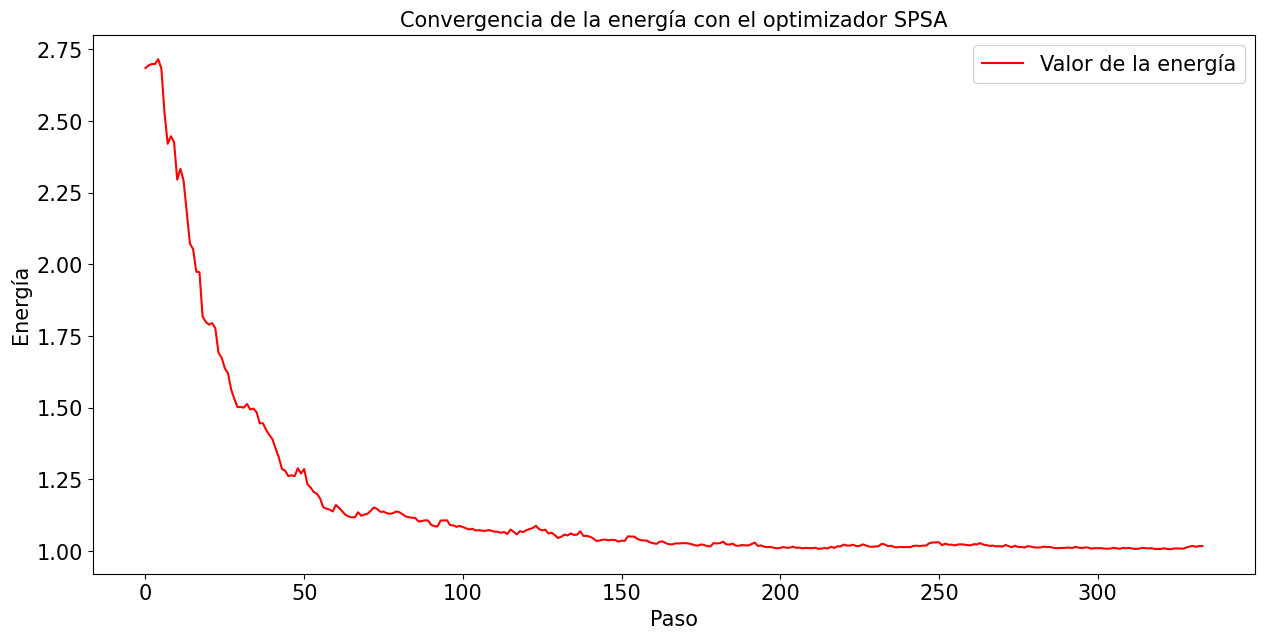

In [15]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(result_energy)), result_energy, label="Valor de la energía", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Paso', fontsize = fontsize)
plt.ylabel('Energía', fontsize = fontsize)
plt.title('Convergencia de la energía con el optimizador SPSA', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize)
plt.show()

Por supuesto, aunque con este código abordamos los principios básicos del algoritmo y podemos obtener una aproximacion decente de $E_G$ para matrices pequeñas, este algoritmo se puede implementar de forma más eficaz, rápida y con mayor precisión en operadores de mayor dimensionalidad.

En resumen, en el algoritmo VQE se fabrica un circuito cuántico (*ansatz*) parametrizado ($\boldsymbol{\theta}$), se ejecuta para obtener el valor esperado del operador problema ($E (\boldsymbol{\theta})$) y se envía el resultado a un optimizador clásico (```SPSA```) para que reajuste los parámetros. A lo largo de varias iteraciones, el algoritmo converge a un valor en torno a $E_G$.

---
Authors:

Irais Bautista ([CESGA](http://www.cesga.es)), Sergio Martínez ([BIFi-UNIZAR](https://bifi.es/es/)), Jaime Scharfhausen ([UAM](https://www.uam.es/uam/inicio)) y Alejandro Jaramillo ([CSUC](https://www.csuc.cat/es))

<img src="https://quantumspain-project.es/wp-content/uploads/2022/11/CESGA.png" width="150px">
<img src="http://bifi.es/wp-content/uploads/2016/11/logo_vectorial-web.png" width="200px">
<img src="https://www.iib.uam.es/iiblf6theme-theme/images/custom/logo-uam.png" width = "200px">
<img src="https://www.csuc.cat/sites/default/files/2021-02/CSUC_logo_corporatiu_0.png" width = "200px">


---
::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 2000px
:align: center
::::

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>